<a href="https://colab.research.google.com/github/johannesmichael/CAS-AML-MD3/blob/main/ElemRL_enemy02-jeremy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# First try at enemy agent following agent with reaction to its location
# Numbered "02" because it's the second homework assignment in RL
## The agent and enemy CAN end up infinitely swapping positions in the bottom right corner, i.e. maximum x,y, in the greedy Q-Max learning
## Therefore limit the number of steps to 2000. This messes up the video recordings.
## See if the smarter Q-Learning can overcome this -- it IS smart that the agent avoids capture but it shouldn't get confined to the corner either

# **Elementary Reinforcement Learning**

Objectives: understanting the usage of environments in the [OpenAI Gym](https://www.gymlibrary.dev/) framework and  implement basic RL algorithms

1.   Manage to create custom environments from the OpenAI Gym framework
2.   Train Q-Learning on one of the custom environments and perform analysis regarding hyper-parameters







Install needed Python packages

In [30]:
#!pip install pygame gym numpy

Import needed Python packages

In [31]:
import gym
from gym import spaces
import pygame
import numpy as np
import random

Mount Google Drive for saving results (not needed if running the notebook locally)

In [32]:
# Mount Google Drive
#from google.colab import drive # import drive from google colab

#ROOT = "/content/drive"         # default location for the drive

#drive.mount(ROOT)              # we mount the google drive at /content/drive

# **1) Create Custom Environments**


# Enemy knows position of agent and moves toward it
- Enemy cannot catch agent if deterministic plan is to move toward agent
- The agent is smart enough to dodge it
- Results in infinite games as agent tries to move off edge of grid and is kept in place by clip
- Random enemy move at distance = 1 is the way to break the stalemate
- See notes in .txt file

In [33]:
class GridWorldEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, render_mode=None, size=5):
        self.size = size  # The size of the square grid
        self.window_size = 512  # The size of the PyGame window

        # Observations are dictionaries with the agent's and the target's location.
        # Each location is encoded as an element of {0, ..., `size`}^2, i.e. MultiDiscrete([size, size]).
        self.observation_space = spaces.Dict(
            {
                "agent": spaces.Box(0, size - 1, shape=(2,), dtype=int),
                "target": spaces.Box(0, size - 1, shape=(2,), dtype=int),
                "enemy": spaces.Box(0, size - 1, shape=(2,), dtype=int),
            }
        )

        # We have 4 actions, corresponding to "right", "up", "left", "down"
        self.action_space = spaces.Discrete(4)

        """
        The following dictionary maps abstract actions from `self.action_space` to 
        the direction we will walk in if that action is taken.
        I.e. 0 corresponds to "right", 1 to "up" etc.
        """
        self._action_to_direction = {
            0: np.array([1, 0]),
            1: np.array([0, 1]),
            2: np.array([-1, 0]),
            3: np.array([0, -1]),
        }

        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode

        """
        If human-rendering is used, `self.window` will be a reference
        to the window that we draw to. `self.clock` will be a clock that is used
        to ensure that the environment is rendered at the correct framerate in
        human-mode. They will remain `None` until human-mode is used for the
        first time.
        """
        self.window = None
        self.clock = None

    # Private method to get observations
    def _get_obs(self):
        return {"agent": self._agent_location, "target": self._target_location, "enemy": self._enemy_location}

    # Private method to get info
    def _get_info(self):
        return {"distance": np.linalg.norm(self._agent_location - self._target_location, ord=1)}
    
    # Reset method for the environment
    def reset(self, seed=None, options=None):
        # We need the following line to seed self.np_random
        super().reset(seed=seed)
#        # Choose target, agent, enemy starting locations
        square_number=range(0,self.size**2)
        start_index=random.sample(square_number, 3)
        a=np.array(square_number).reshape(self.size,self.size)

        self._agent_location=np.asarray(np.unravel_index(start_index[0],a.shape))
        self._enemy_location=np.asarray(np.unravel_index(start_index[1],a.shape))
        self._target_location=np.asarray(np.unravel_index(start_index[2],a.shape))

        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, info

    # Step method for the environment
    def step(self, action):

# enemy action = 0,1,2,3
# choose which one based on shortest path to agent's location in last step
# if minimum distance to agent is only one square, move randomly
        
        enemy_action=-1
        mindist=1000.
        grid_distance = self._agent_location - self._enemy_location
 #       print(f" grid_distance {grid_distance[0]} {grid_distance[1]}")
 # Use range (0,3) here if it doesn't change the result ?!
        for i in range(4):
           if np.linalg.norm(grid_distance-self._action_to_direction[i]) <= mindist:
                mindist=np.linalg.norm(grid_distance-self._action_to_direction[i])
                enemy_action=i
        #if mindist < 1:
        #    enemy_action = self.action_space.sample()
            #print(f"before clip mindist {mindist} {self._enemy_location} {self._agent_location}")
        # Map the action (element of {0,1,2,3}) to the direction we walk 
        direction_enemy = self._action_to_direction[enemy_action]
        direction_agent = self._action_to_direction[action]

        # We use `np.clip` to make sure we don't leave the grid
        self._agent_location = np.clip(self._agent_location + direction_agent, 0, self.size - 1)
        self._enemy_location = np.clip(self._enemy_location + direction_enemy, 0, self.size - 1)
        
        #    print(f"after clip mindist {mindist} {self._enemy_location} {self._agent_location}")

        # An episode is done if the agent has reached the target, hit the enemy or if enemy reaches target
        reward=0
        terminated = np.array_equal(self._agent_location, self._target_location) or np.array_equal(self._agent_location, self._enemy_location) or np.array_equal(self._target_location, self._enemy_location)
        won = np.array_equal(self._target_location, self._agent_location)
        caught = np.array_equal(self._agent_location, self._enemy_location)
        lost = np.array_equal(self._enemy_location, self._target_location)
    
     #   reward = 1 if terminated else 0  # Binary sparse rewards
        if terminated == False:
            reward=0
        if terminated and won:
            reward=100.0
        elif terminated and caught:
            reward=-0.5
        elif terminated and lost:
            reward=-1.0

        observation = self._get_obs()
        info = self._get_info()
       # info = print(f"Terminated. Reward = {reward}")

        if self.render_mode == "human":
            self._render_frame()

        return observation, reward, terminated, False, info

    # Render method for visualization
    def render(self):
        if self.render_mode == "rgb_array":
            return self._render_frame()

    def _render_frame(self):
        if self.window is None and self.render_mode == "human":
            pygame.init()
            pygame.display.init()
            self.window = pygame.display.set_mode((self.window_size, self.window_size))
        if self.clock is None and self.render_mode == "human":
            self.clock = pygame.time.Clock()

        canvas = pygame.Surface((self.window_size, self.window_size))
        canvas.fill((255, 255, 255))
        pix_square_size = (
            self.window_size / self.size
        )  # The size of a single grid square in pixels

        # First we draw the target
        pygame.draw.rect(
            canvas,
            (255, 0, 0),
            pygame.Rect(
                pix_square_size * self._target_location,
                (pix_square_size, pix_square_size),
            ),
        )
        # Now we draw the agent
        pygame.draw.circle(
            canvas,
            (0, 0, 255),
            (self._agent_location + 0.5) * pix_square_size,
            pix_square_size / 3,
        )

        # Draw enemy
        pygame.draw.circle(canvas,(0,0,0),(self._enemy_location + 0.5) * pix_square_size, pix_square_size/3,)

        # Finally, add some gridlines
        for x in range(self.size + 1):
            pygame.draw.line(
                canvas,
                0,
                (0, pix_square_size * x),
                (self.window_size, pix_square_size * x),
                width=3,
            )
            pygame.draw.line(
                canvas,
                0,
                (pix_square_size * x, 0),
                (pix_square_size * x, self.window_size),
                width=3,
            )

        if self.render_mode == "human":
            # The following line copies our drawings from `canvas` to the visible window
            self.window.blit(canvas, canvas.get_rect())
            pygame.event.pump()
            pygame.display.update()

            # We need to ensure that human-rendering occurs at the predefined framerate.
            # The following line will automatically add a delay to keep the framerate stable.
            self.clock.tick(self.metadata["render_fps"])
        else:  # rgb_array
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
            )


Imports and functions for recording/showing videos for random policy on `GridEnv`

In [34]:
from gym.wrappers import RecordVideo
from pathlib import Path
import base64
from IPython import display as ipythondisplay

In [35]:
# Set up fake display; otherwise rendering will fail on Google Colab
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

In [36]:
def show_videos(video_path='', prefix=''):
  html = []
  for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
      video_b64 = base64.b64encode(mp4.read_bytes())
      html.append('''<video alt="{}" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                </video>'''.format(mp4, video_b64.decode('ascii')))
  ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

Record video of ten steps for random policy on `GridEnv` environment

In [37]:
import sys
import os

is_colab = 'google.colab' in sys.modules
root_dir ='drive/MyDrive/CASAdvancedML' if is_colab else '.'

In [38]:
video_folder = os.path.join(root_dir, 'Videos')
os.makedirs(video_folder, exist_ok=True)

grid_size = 5

# set video_length, episode_trigger, step_trigger
gwenv = GridWorldEnv(render_mode='rgb_array', size=grid_size)


# **2) Q-Learning**

## Q-Learning on `GridWorldEnv`

Function to inizialize the Q table

In [39]:
def initializeQ(gwenv):
  Q = np.zeros((gwenv.size, gwenv.size,   # x and y for agent
                gwenv.size, gwenv.size,   # x and y for enemy
                gwenv.size, gwenv.size,   # x and y for target
                gwenv.action_space.n))    # actions
  return Q


Function to run one episode of the algorithm on `GridWorldEnv`

In [40]:
def run_episode_gwenv(env, Q, lr, discount, epsilon=0.1, render=False, _maxsteps=2000, optimal=False):

	observation, _ = env.reset()
	done = False
	nsteps = 0

#	for x in range(_maxsteps):
	while done == False:


		nsteps += 1

		if done:
			break

		if render:
			env.render()

		curr_state = observation

		# handle multi dims of Q table
		ax = curr_state['agent'][0]
		ay = curr_state['agent'][1]
		ex = curr_state['enemy'][0]
		ey = curr_state['enemy'][1]
		tx = curr_state['target'][0]
		ty = curr_state['target'][1]

		# training time
		if not optimal:

			# Epsilon-greedy policy
			randnum = np.random.rand(1)
			if randnum < epsilon:
				action = env.action_space.sample()
			else:
				action = np.argmax(Q[ax, ay, ex, ey, tx, ty,:])
		
			observation, reward, done, _, info = env.step(action)
		
			# handle multi-dims of Q table
			ax_next = observation['agent'][0]
			ay_next = observation['agent'][1]
			ex_next = observation["enemy"][0]
			ey_next = observation["enemy"][1]
			tx_next = observation['target'][0]
			ty_next = observation['target'][1]

			#Q(state, action) = R(state, action) + Gamma * Max[Q(next state, all actions)]
		#	Q[ax, ay, tx, ty, action] += lr * (reward+ discount*np.max(Q[ax_next, ay_next, tx_next, ty_next, :]) - Q[ax, ay, tx, ty, action])
			Q[ax, ay, ex, ey, tx, ty, action] += lr * (reward+ discount*np.max(Q[ax_next, ay_next, ex_next, ey_next, tx_next, ty_next, :]) - Q[ax, ay, ex, ey, tx, ty, action])

		# evaluation time
		else:
			action = np.argmax(Q[ax, ay, ex, ey, tx, ty,:])
		#	action = np.argmax(Q[ax, ay, tx, ty,:])
			observation, reward, done, _, info = env.step(action)
			if nsteps == _maxsteps:
				print(f"action {action} Q {Q[ax, ay, ex, ey, tx, ty,action]} ax {ax} ay {ay} ex {ex} ey {ey}")
				done = True
			if done == True:
				print(f"Game Over! {nsteps} steps {done} reward {reward}")

	return Q, reward


Function to run Q-Learning

In [41]:
from pyparsing.helpers import Callable
from tqdm import tqdm

def QLearning(env: gym.Env, num_episodes: int, initQ: Callable, run_episode: Callable, config: dict):

	reward_per_ep = list()
	Q = initQ(env)

	for i in tqdm(range(num_episodes)):
		Q, reward = run_episode(env, Q, **config)
		reward_per_ep.append(reward)

	return Q, reward_per_ep



Train Q-Learning on `GridWorldEnv`

In [42]:
config = {}
config['lr'] = 0.3#.5
config['discount'] = 0.99#0.99
config['epsilon'] = 0.25#0.1
num_episodes = 30000#10000

Q_trained, reward_per_ep = QLearning(gwenv,
                                  	num_episodes,
									initQ=initializeQ,
									run_episode=run_episode_gwenv,
									config=config)

100%|██████████| 30000/30000 [00:26<00:00, 1133.77it/s]


Plot learning curve (i.e., average reward over fixed window)

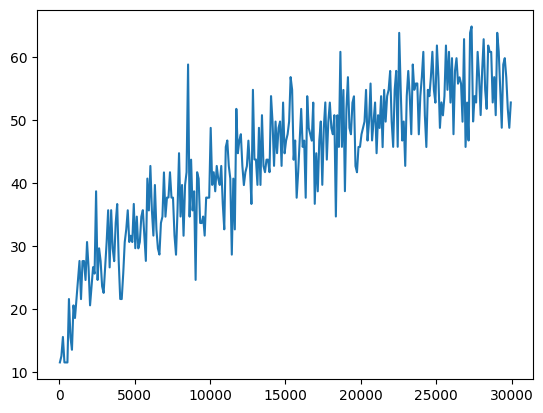

In [43]:
from matplotlib import pyplot as plt

def averagewindow(R, d=1):
    n = len(R)
    t = []
    y = []
    for i in range(0,int(n/d)):
        t.append(np.mean(range(i*d,(i+1)*d)));
        y.append(np.mean(R[i*d:min(n,(i+1)*d)]))
    return t,y

window = 100
t,y = averagewindow(reward_per_ep, d=window)
plt.plot(t, y)

Record video in inference mode

In [44]:
config['optimal'] = True                  # no learning anymore
config['render'] = True                   # render for recording
initQ_trained = lambda env: Q_trained     # dummy function that returns the trained Q table
prefix = 'gwenv_followenemy_q'
vid_episodes = 10

# use wrapper to record videos
gwenv_vid = RecordVideo(gwenv, 
                        video_folder=video_folder,
                        episode_trigger=lambda ep: (ep < vid_episodes),
                        step_trigger=None,
                        video_length=0,
                        name_prefix=prefix,
                        new_step_api=True
                        )

# use wrapper to record videos
Q_trained, reward_per_ep_test = QLearning(gwenv_vid,
                                          num_episodes=vid_episodes,
                                          initQ=initQ_trained,
                                          run_episode=run_episode_gwenv,
                                          config=config)

 10%|█         | 1/10 [00:00<00:02,  3.20it/s]

Game Over! 1 steps True reward 100.0


 20%|██        | 2/10 [00:00<00:02,  3.08it/s]

Game Over! 8 steps True reward 100.0


 30%|███       | 3/10 [00:01<00:02,  2.92it/s]

Game Over! 18 steps True reward 100.0


 40%|████      | 4/10 [00:01<00:02,  2.92it/s]

Game Over! 9 steps True reward 100.0


 50%|█████     | 5/10 [00:01<00:01,  2.89it/s]

Game Over! 15 steps True reward 100.0


 60%|██████    | 6/10 [00:02<00:01,  2.92it/s]

Game Over! 8 steps True reward 100.0


 70%|███████   | 7/10 [00:02<00:01,  2.96it/s]

Game Over! 7 steps True reward 100.0


 80%|████████  | 8/10 [00:02<00:00,  3.05it/s]

Game Over! 1 steps True reward 100.0


 90%|█████████ | 9/10 [00:03<00:00,  2.75it/s]

Game Over! 8 steps True reward 100.0


100%|██████████| 10/10 [00:03<00:00,  2.80it/s]

Game Over! 9 steps True reward 100.0


Play videos over some episodes

In [45]:
show_videos(video_folder, prefix=prefix)